# Word Embeddings

Yeah, what the heck are embeddings? First time I heard the word I tought it was kind of slime monster with a lot of stuff glued to it... I mean, embeddings are **almost** something like that.

Whenever we talk about ChatBots, we are fundamentally talking about encoder-decoder models with a gigantic layer of Neural Networks and a mechanism called multi-head attention attached to it. 

<img title="a title" alt="Alt text" src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width=350px>

It may sound a lot, and I made sure to set up the diagram above, just to make things more clear to anyone: **embeddings are at the very core of AI.**

How are they useful: instead of translate a given string to it's value in binary (utf-8) for example, embeddings are neural networks specialized in word differentiation.

They are trained in a simple process: **predict the next set of tokens based on a given input.**

The result of a large training process (you will also need a gigantic training set) is a model capable of positioning a set of tokens into a vector space, and clearly position the distance between phrases.

Say you have 3 different phrases:

"I love my dog." (1)

"I love my cat." (2)

"I love my car." (3)

Translating theses phrases directly into binary, it's numerical form would give a similarity score bigger for phrases 2 and 3. But given the context, cats and dogs are talking about a pet, therefore, 1 and 2 should be "closer" to each other.

Ok, but why does it matter knowing word embeddings to understand One Piece? Don't you wish to know which sagas are more similar to each other based on the word embeddings of their topn tokens? Let's do it!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

import umap.umap_ as umap

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# !python -m spacy download en_core_web_trf
import spacy
nlp = spacy.load("en_core_web_trf")

from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def top_n_idx_sparse(matrix, n):
    """Return index of top n values in each row of a sparse matrix."""
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        top_n_idx.append(
            matrix.indices[
                le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]
            ]
        )
    return top_n_idx


def preprocess_tokens(string: str) -> str:
    """Get a crude unprocessed string and return a filtered and standardized version of the input"""
    doc = nlp(string)
    out = [
        token.lemma_ for token in doc
        if token.pos_ in ("NOUN", "VERB")
    ]
    return " ".join(out)


def get_word_freq_by_group(string: str) -> str:
    pass

onepiecedata = pd.read_parquet("../outputs/volume.parquet")
onepiecedata.head(10)

/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
amdgpu.ids: No such file or directory


,volume,text,saga,saga_expanded
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town
2,3,could they have finished with him already. he ...,East Blue,Orange Town
3,4,your swords. before we fight id better. they c...,East Blue,Syrup Village
4,5,hes the cannon man. brother they say. captured...,East Blue,Baratie
5,6,better take it easy. whos krieg. then fight me...,East Blue,Baratie
6,7,ha you can tell youre a green horn. b bones. p...,East Blue,Baratie
7,8,hatchan hachi arlongs first mate. if some thin...,East Blue,Arlong Park
8,9,having seen the strong hold of this pirate. go...,East Blue,Arlong Park
9,10,is the maximum you can hold you have no chance...,East Blue,Arlong Park


In [2]:
cache_path = "../outputs/processed_onepiecedata.parquet"
if os.path.isfile(cache_path):
    onepiecedata = pd.read_parquet("../outputs/processed_onepiecedata.parquet")
else:
    onepiecedata["processed_text"] = onepiecedata["text"].apply(lambda x:preprocess_tokens(x))
    onepiecedata.to_parquet("../outputs/processed_onepiecedata.parquet")

onepiecedata_by_saga = onepiecedata.groupby("saga")["processed_text"].apply(lambda x: " ".join(x)).reset_index()
onepiecedata_by_saga

,saga,processed_text
0,Alabasta,go re monster welcome know organization die le...
1,Amazon Lily,clothe throw bubble caudron call bath name re ...
2,Dressrosa,call get power hell ring hell ring luck make p...
3,East Blue,do self have untie s prison s guy think s idea...
4,Enies Lobby,matter return go say take crew member one it a...
5,Fish-Man Island,guy look man skew spear grit behold transforma...
6,Impel Down,know s forget food escape level sake blood it ...
7,Marineford,happ pen freeze shut trap pup take battlefield...
8,Post-War,think listen re set fire find captain way sepa...
9,Punk Hazard,look s robot send soldier handle navy stop nig...


I only need to convert every token to it's vector form. But we will have a problem here: how can we aggregate all those vectors into a single one, in order to visualize distances?

Let's simplify: I'll use the same idea I've used last chapter and filter for top 100 tokens based on tfidf and spacy POS filtering.

In [3]:
# Get top tokens for each saga
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata_by_saga["processed_text"])
words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)]


# Function to filter words in text
def filter_text(text, word_list):
    text_words = text.split()  # Split text into words
    filtered_words = [word for word in text_words if word in word_list]  # Keep only matching words
    return " ".join(filtered_words)  # Reconstruct the text

# Apply filtering to create the new column
onepiecedata_by_saga["simpler_text"] = [filter_text(text, words[i]) for i, text in enumerate(onepiecedata_by_saga["processed_text"])]

onepiecedata_by_saga

,saga,processed_text,simpler_text
0,Alabasta,go re monster welcome know organization die le...,monster know die island line come sword man st...
1,Amazon Lily,clothe throw bubble caudron call bath name re ...,throw say care warlord floor impel capture esc...
2,Dressrosa,call get power hell ring hell ring luck make p...,power make know factory need coliseum fruit fr...
3,East Blue,do self have untie s prison s guy think s idea...,guy think make look fight tell stand sea make ...
4,Enies Lobby,matter return go say take crew member one it a...,say shut kick cut body enemy lose way governme...
5,Fish-Man Island,guy look man skew spear grit behold transforma...,guy look man time time time head feel know loo...
6,Impel Down,know s forget food escape level sake blood it ...,know escape level blood break prison chance wa...
7,Marineford,happ pen freeze shut trap pup take battlefield...,shut man cut die kill rest world head bay kid ...
8,Post-War,think listen re set fire find captain way sepa...,think set captain way run people want burn kin...
9,Punk Hazard,look s robot send soldier handle navy stop nig...,look stop way use poison gas mean ship captain...


One way I can aggregate all those tokens now is my generating a vector for each token and applying a aggregating function. 

I'll avoid outliers by using the median vector of all those tokens and as for the embedding model, I'll use [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

Here is an example of how it works:

In [4]:
word = "monster"
embeddings = model.encode(word)
print(f"Word encoded: {word}. \nVector of shape: {embeddings.shape}. \nIt's first 22 values are: \n{embeddings[0:21]}")

Word encoded: monster. 
Vector of shape: (384,). 
It's first 22 values are: 
[-0.06246408  0.06257132 -0.0295779   0.09097833 -0.03252928 -0.04142079
  0.05643532  0.03199346 -0.0006376  -0.08480067 -0.0782826  -0.05253912
 -0.02965334  0.00217773 -0.009474    0.03584204  0.04320558  0.04229356
 -0.03907976 -0.08186977 -0.02451601]


/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


This specific embedding model maps a given string into a vector of 384 dimentions. 

If we were to plot this, it would be impossible to even comprehend all those dimentions. 

One thing that we can do is reduce dimentionality by applying UMAP. (You could use any other model, but UMAP is more suitable as it preserves the global structure of the data.)

But first, lets apply this transformation in a unified way.

In [5]:
def process_textual_column(row):
    """Takes a textual row and return the median embedding of all words."""
    sentences = row.split()
    embeddings = model.encode(sentences)
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

In [6]:
onepiecedata_by_saga["avg_embedding"] = onepiecedata_by_saga["simpler_text"].apply(lambda row: process_textual_column(row))
onepiecedata_by_saga

,saga,processed_text,simpler_text,avg_embedding
0,Alabasta,go re monster welcome know organization die le...,monster know die island line come sword man st...,"[-0.03578086, 0.039426595, -0.013476978, 0.008..."
1,Amazon Lily,clothe throw bubble caudron call bath name re ...,throw say care warlord floor impel capture esc...,"[-0.044486165, 0.031794768, -0.022246296, 0.00..."
2,Dressrosa,call get power hell ring hell ring luck make p...,power make know factory need coliseum fruit fr...,"[-0.038642004, 0.039321795, -0.016012283, 0.00..."
3,East Blue,do self have untie s prison s guy think s idea...,guy think make look fight tell stand sea make ...,"[-0.043739513, 0.041489124, -0.01431982, 0.007..."
4,Enies Lobby,matter return go say take crew member one it a...,say shut kick cut body enemy lose way governme...,"[-0.039522655, 0.038843382, -0.012872513, 0.01..."
5,Fish-Man Island,guy look man skew spear grit behold transforma...,guy look man time time time head feel know loo...,"[-0.03988952, 0.036256257, -0.013040341, 0.005..."
6,Impel Down,know s forget food escape level sake blood it ...,know escape level blood break prison chance wa...,"[-0.0466334, 0.03730525, -0.025430009, 0.00883..."
7,Marineford,happ pen freeze shut trap pup take battlefield...,shut man cut die kill rest world head bay kid ...,"[-0.042971704, 0.043566238, -0.013630741, 0.00..."
8,Post-War,think listen re set fire find captain way sepa...,think set captain way run people want burn kin...,"[-0.040815745, 0.040101, -0.015082427, 0.00828..."
9,Punk Hazard,look s robot send soldier handle navy stop nig...,look stop way use poison gas mean ship captain...,"[-0.039041482, 0.03543901, -0.017083585, 0.010..."


In [7]:
embeddings = np.vstack(onepiecedata_by_saga["avg_embedding"].values)
fit = umap.UMAP(
    random_state=12,
    n_components=2
).fit(embeddings)
umap_embedding = fit.embedding_

/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


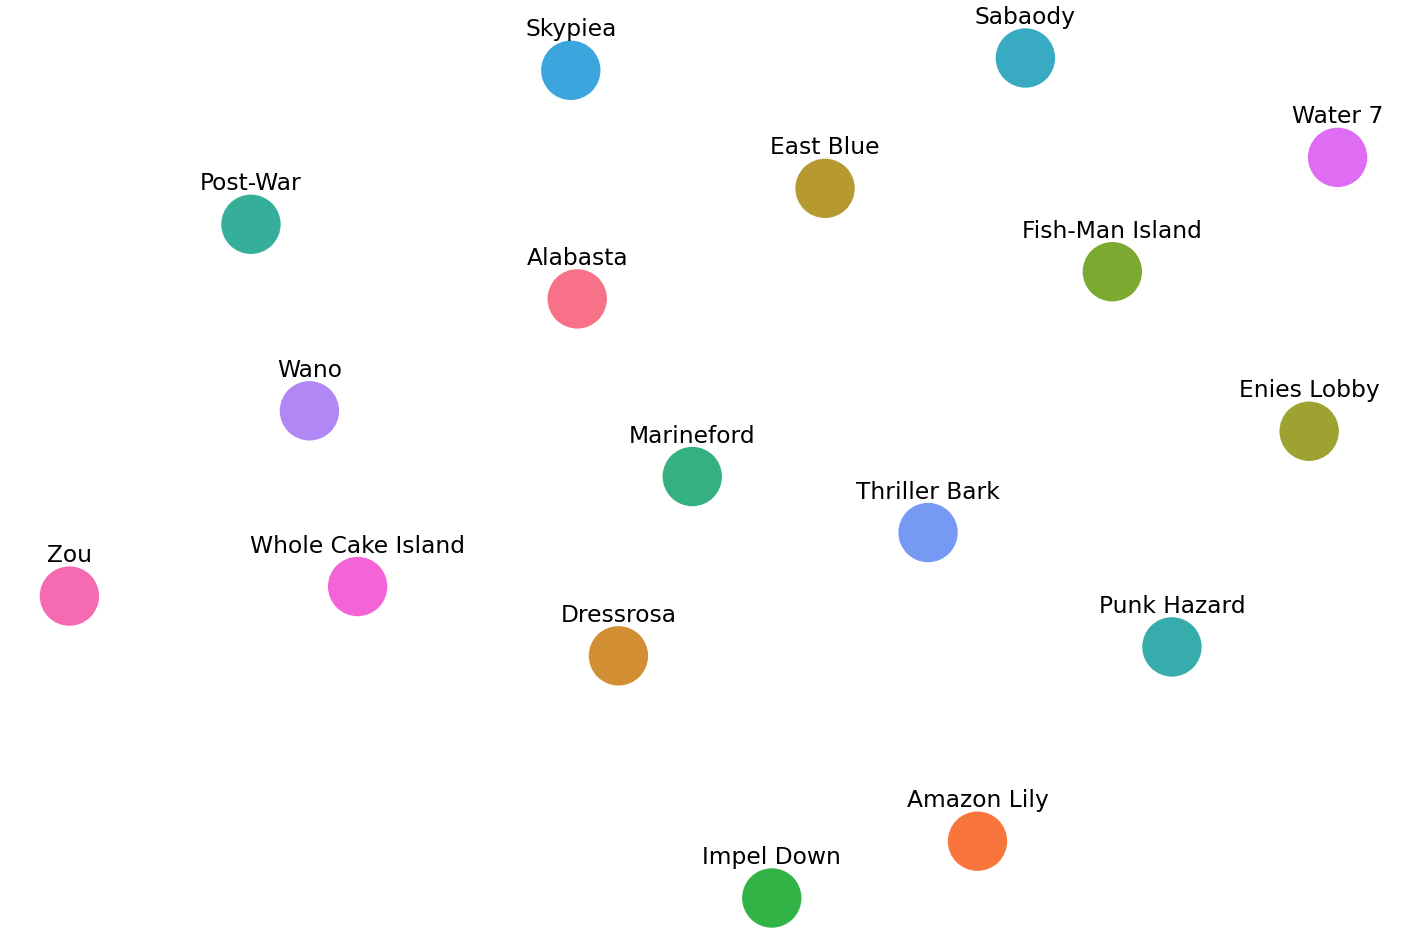

In [8]:
oneonepiecedata_by_saga_visual = pd.DataFrame({"X":umap_embedding[:, 0], "Y":umap_embedding[:, 1], "saga":onepiecedata_by_saga["saga"]})

fig, ax = plt.subplots(figsize=(30, 20), dpi=60)
sns.scatterplot(x="X", y="Y", data=oneonepiecedata_by_saga_visual, hue="saga", s=6000)  # alpha=0 remove os pontos

# Adicionar os textos ao invés dos pontos
for _, row in oneonepiecedata_by_saga_visual.iterrows():
    plt.text(row["X"], row["Y"] + 0.14, row["saga"], fontsize=28, ha='center', va='center')

# Remover a legenda
plt.legend([], [], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
# ax.set_title("Distances Between Top 100 words by Saga", pad=20, fontsize=25)
plt.show()


This means that If we take Skypea's word cloud and compare it to East Blue's, both visuals should have similarities, and when comparing Skypea with Impel Down, words should differ more.

In [9]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata_by_saga["processed_text"])

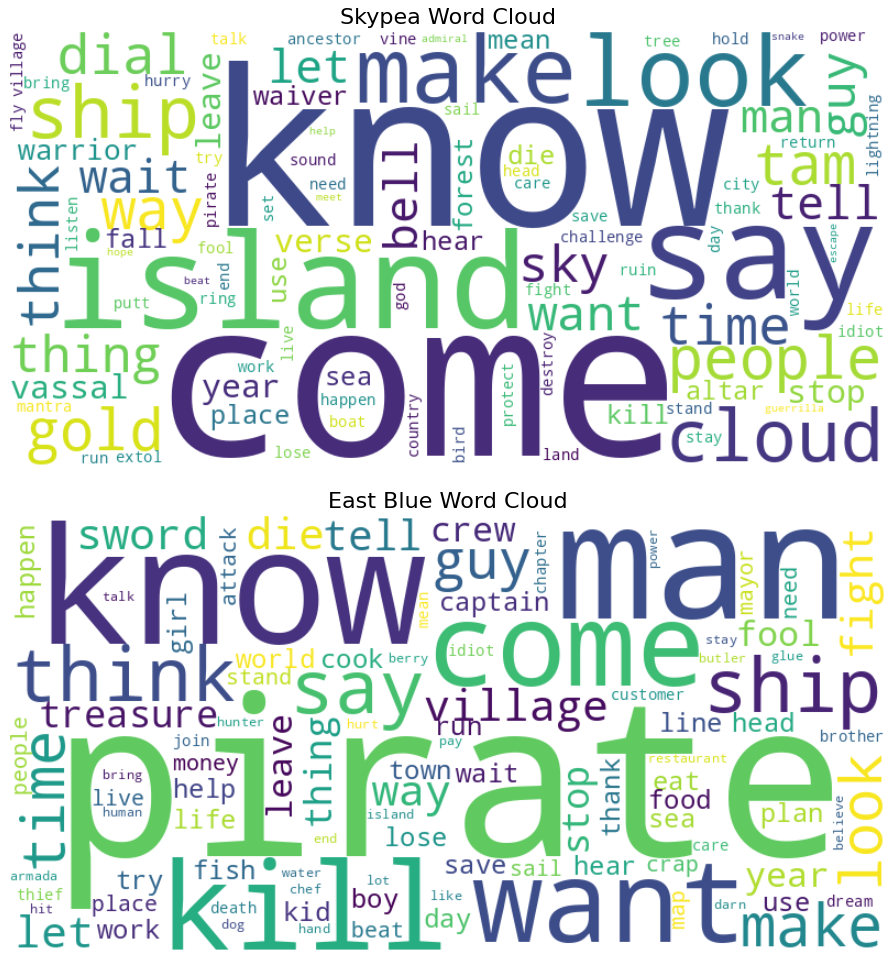

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(25, 15), dpi=80)
fig.subplots_adjust(hspace=0.1)

# First word cloud
words_1 = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][11]
sizes_1 = X[11, top_n_idx_sparse(X, 100)[11]].toarray().ravel()
frequencies_1 = {word: size for word, size in zip(words_1, sizes_1)}

wordcloud_1 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies_1)

axes[0].imshow(wordcloud_1, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Skypea Word Cloud", fontsize=20)

# Second word cloud
words_2 = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][3]
sizes_2 = X[3, top_n_idx_sparse(X, 100)[3]].toarray().ravel()
frequencies_2 = {word: size for word, size in zip(words_2, sizes_2)}

wordcloud_2 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies_2)

axes[1].imshow(wordcloud_2, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("East Blue Word Cloud", fontsize=20)

plt.show()

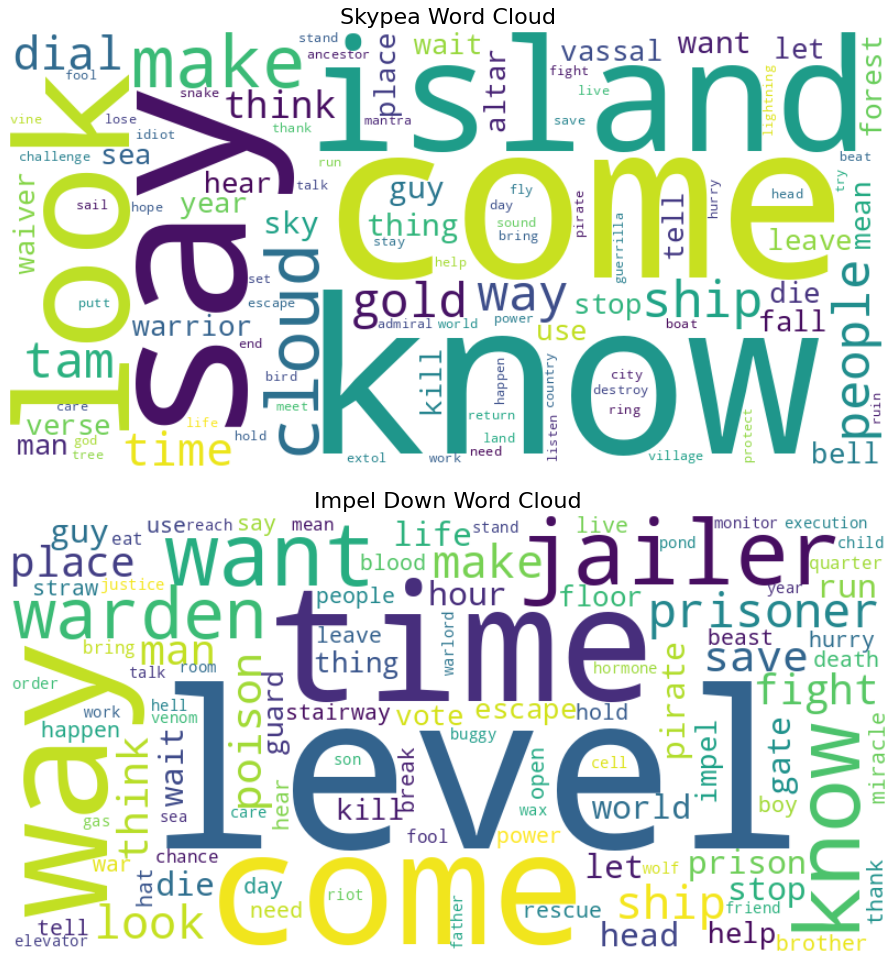

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(25, 15), dpi=80)
fig.subplots_adjust(hspace=0.1)

# First word cloud
words_1 = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][11]
sizes_1 = X[11, top_n_idx_sparse(X, 100)[11]].toarray().ravel()
frequencies_1 = {word: size for word, size in zip(words_1, sizes_1)}

wordcloud_1 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies_1)

axes[0].imshow(wordcloud_1, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Skypea Word Cloud", fontsize=20)

# Second word cloud
words_2 = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][6]
sizes_2 = X[6, top_n_idx_sparse(X, 100)[6]].toarray().ravel()
frequencies_2 = {word: size for word, size in zip(words_2, sizes_2)}

wordcloud_2 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies_2)

axes[1].imshow(wordcloud_2, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Impel Down Word Cloud", fontsize=20)

plt.show()

It is already giving us a sense of how words are introducing specific topics into the whole story. This is a common advantage of using word embeddings to learn general context from textual features. 

**And HERE COMES THE BUT!**

Notice that I've simplified all to currently look at distances between sagas by looking at top 100 tokens with POS filtering. This is already a way of fundamentally grasp at token relationships inside the dataset, but it's not efficient.

Instead of going all the way into feature selection to provide the best possible tokens for our analysis, the embedding model is capable of doing that on a sentence level.

Here is an example:


In [12]:
model.encode("I'll become king of the pirates!")

array([-7.82719254e-02,  4.99064215e-02, -9.61178821e-03, -7.98748340e-03,
       -2.37850938e-02, -4.43114117e-02, -7.67020509e-03, -4.45897058e-02,
       -2.81801708e-02,  2.14858213e-03, -9.12978947e-02, -4.92499135e-02,
        8.41280445e-02, -7.12409941e-03, -1.86016429e-02,  4.70047407e-02,
        4.67098597e-03,  4.43466045e-02,  1.22378040e-02,  6.76851645e-02,
        9.53555456e-04,  3.14468779e-02, -6.57529756e-02, -3.00411927e-03,
       -8.05071518e-02,  9.17431619e-03,  2.55506672e-02,  4.09286506e-02,
       -7.53595307e-02, -5.80522679e-02, -1.66219827e-02,  2.23315246e-02,
       -2.41589006e-02,  7.33278096e-02,  2.33798306e-02, -8.98401532e-03,
        4.54758145e-02, -4.93778996e-02,  5.57801090e-02,  3.52478251e-02,
        3.10367104e-02, -2.20745988e-02, -2.87477653e-02,  8.15869570e-02,
        2.74555590e-02, -7.38487020e-02, -4.05224226e-02,  4.82115224e-02,
        3.75914667e-03,  4.37220521e-02,  5.16161043e-03,  4.41721417e-02,
       -1.28816599e-02,  

Passing a phrase is a way of measuring where the entire context of the phrase should be in the vector space of the embedding model.

So we can do something like this:

In [13]:
def process_textual_column(row):
    """Takes a textual row and return the median embedding of all words."""
    sentences = row.split(".")
    embeddings = model.encode(sentences)
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

onepiecedata_avg_embeddings = onepiecedata.groupby("saga")["text"].apply(lambda row: process_textual_column(". ".join(row))).reset_index(name="avg_embedding")
onepiecedata_avg_embeddings

,saga,avg_embedding
0,Alabasta,"[-0.020444952, 0.019179462, 0.0047531542, 0.00..."
1,Amazon Lily,"[-0.021424817, 0.015150221, 0.0019530496, 0.00..."
2,Dressrosa,"[-0.019325884, 0.02238516, 0.0021725935, -0.00..."
3,East Blue,"[-0.021873271, 0.020940907, 0.00537054, -4.292..."
4,Enies Lobby,"[-0.022214478, 0.019378914, 0.0018026774, 0.00..."
5,Fish-Man Island,"[-0.017522627, 0.02357069, 0.0069043175, -0.00..."
6,Impel Down,"[-0.021963358, 0.019450545, -0.0027267362, 0.0..."
7,Marineford,"[-0.026526308, 0.024251567, -8.9268215e-06, -0..."
8,Post-War,"[-0.017556429, 0.01733348, 0.005260131, 0.0022..."
9,Punk Hazard,"[-0.01924723, 0.019361135, 0.004084265, 0.0030..."


/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


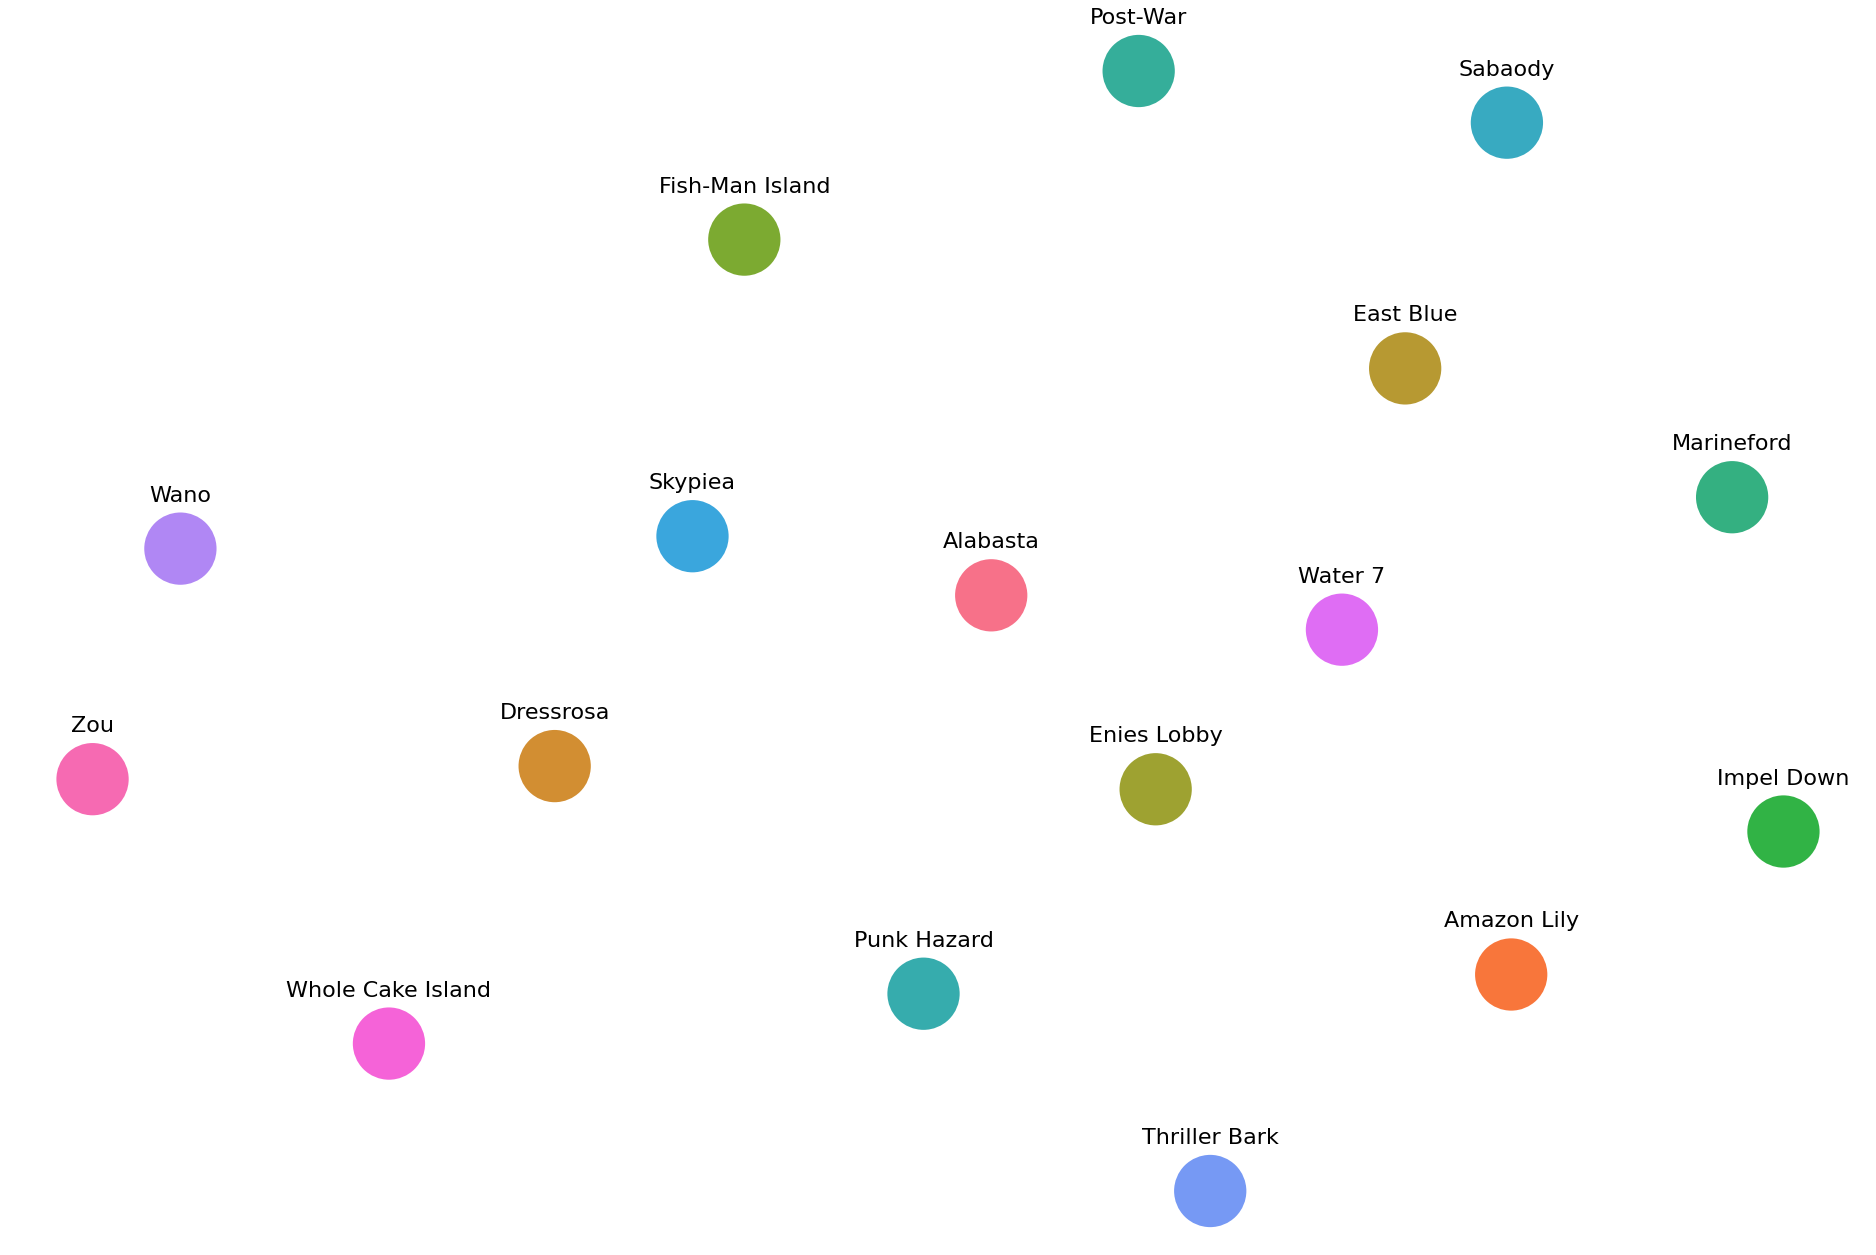

In [14]:
embeddings = np.vstack(onepiecedata_avg_embeddings["avg_embedding"].values)
fit = umap.UMAP(
    random_state=12,
    n_components=2
).fit(embeddings)
umap_embedding = fit.embedding_

oneonepiecedata_by_saga_visual = pd.DataFrame({"X":umap_embedding[:, 0], "Y":umap_embedding[:, 1], "saga":onepiecedata_avg_embeddings["saga"]})

fig, ax = plt.subplots(figsize=(30, 20), dpi=80)
sns.scatterplot(x="X", y="Y", data=oneonepiecedata_by_saga_visual, hue="saga", s=5000)  # alpha=0 remove os pontos

# Adicionar os textos ao invés dos pontos
for _, row in oneonepiecedata_by_saga_visual.iterrows():
    plt.text(row["X"], row["Y"] + 0.13, row["saga"], fontsize=20, ha='center', va='center')

# Remover a legenda
plt.legend([], [], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
# ax.set_title("Phrase Differences by Saga", pad=20, fontsize=25)
plt.show()

And this visual represents the similarity between spoken phrases in different sagas.

I think it's harder to make sense of whats happening when we look at things this way. 

When looking at words, we can filter out most of the "bad" tokens and look at wordclouds to grasp at whats happening. At a sentence level this cannot be done easily.

But this is the complexity of NLP: making sense of text patterns that cannot be clearly visualized.

This topic is now over (for the moment) and it's logical continuation is `ContextualTop2Vec.ipynb`.